In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import string
import os
import random
import scispacy #https://allenai.github.io/scispacy/
import spacy
import en_core_web_sm

/Users/haoxueli/opt/anaconda3/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
df = pd.read_csv('data/NOTEEVENTS.csv')

/Users/haoxueli/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#  SUBJECT_ID refers to a unique patient, 
#  HADM_ID refers to a unique admission to the hospital
print("Number of unique patient: ",len(df.groupby(['SUBJECT_ID'])['SUBJECT_ID']))
print("Number of unique admission to the hospital: ",len(df.groupby(['HADM_ID'])['HADM_ID']))

Number of unique patient:  46146
Number of unique admission to the hospital:  58361


In [5]:
df.loc[:5]

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...
5,179,53181,170490.0,2172-03-08,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2172-3-5**] D...


# Split

In [6]:
# split according to patients
df_now=df

In [7]:
length=len(df_now.groupby(['SUBJECT_ID'])['SUBJECT_ID'])

In [8]:
patient_train=random.sample(list(df_now['SUBJECT_ID'].unique()),int(length*0.985))
df_now["patient_split"]=df_now['SUBJECT_ID'].isin(patient_train)

In [9]:
df_patient_train=df_now[df_now["patient_split"]==True]
df_patient_val=df_now[df_now["patient_split"]==False]
# examine
l1=len(df_patient_train["SUBJECT_ID"].unique())
l2=len(df_patient_val["SUBJECT_ID"].unique())
print(l1,l2,l1/(l1+l2))

45453 693 0.9849824470159927


In [10]:
print("the number of notes in training set: ",len(df_patient_train))
print("the number of notes in val set: ",len(df_patient_val))

the number of notes in training set:  2050813
the number of notes in val set:  32367


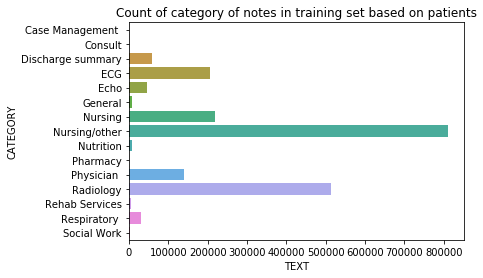

In [11]:
# training set
df_patient_train_cat = df_patient_train.groupby("CATEGORY").count()[["TEXT"]].reset_index()
plt.title("Count of category of notes in training set based on patients")
sns.barplot(y="CATEGORY", x="TEXT", data=df_patient_train_cat)
plt.show()

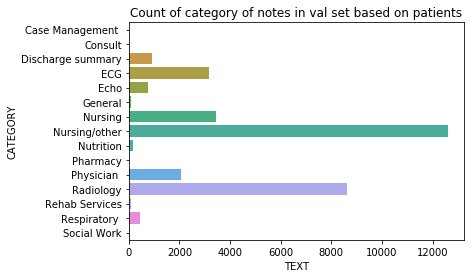

In [12]:
# training set
df_patient_val_cat = df_patient_val.groupby("CATEGORY").count()[["TEXT"]].reset_index()
plt.title("Count of category of notes in val set based on patients")
sns.barplot(y="CATEGORY", x="TEXT", data=df_patient_val_cat)
plt.show()

In [13]:
df_patient_val.groupby("CATEGORY").count()["TEXT"]

CATEGORY
Case Management          4
Consult                  2
Discharge summary      909
ECG                   3150
Echo                   767
General                 92
Nursing               3427
Nursing/other        12595
Nutrition              148
Pharmacy                 2
Physician             2071
Radiology             8604
Rehab Services          92
Respiratory            440
Social Work             64
Name: TEXT, dtype: int64

In [14]:
df_patient_train.groupby("CATEGORY").count()["TEXT"]

CATEGORY
Case Management         963
Consult                  96
Discharge summary     58743
ECG                  205901
Echo                  45027
General                8209
Nursing              220129
Nursing/other        809902
Nutrition              9270
Pharmacy                101
Physician            139553
Radiology            513675
Rehab Services         5339
Respiratory           31299
Social Work            2606
Name: TEXT, dtype: int64

In [15]:
df_patient_train.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT',
       'patient_split'],
      dtype='object')

# Preprocess

In [16]:
# STEP 3: Preprocessing
def preprocess1(x):
    '''
    This preprocessing does
    1. Remove bullet points.
    2. Fix 'dr.' and 'm.d.' abbreviation.
    3. Remove '-' and '=='.
    4. Remove space, keep digits for later preprocessing.
    '''
    
#     y=re.sub('\\[(.*?)\\]','',x) #remove de-identified brackets
    # remove bullepoint like number (what if it's 5.5 mg)
    y=re.sub('[0-9]+\.','',x) #remove 1.2. since the segmenter segments based on this
    y=re.sub('dr\.','doctor',y)
    y=re.sub('m\.d\.','md',y)
    # these two kind of make sense
    # y=re.sub('admission date:','',y)
    # y=re.sub('discharge date:','',y)
    
    y=re.sub('--|__|==','',y)
    
    # remove all digits, spaces
    y = y.translate(str.maketrans("", ""))
    # y = y.translate(str.maketrans("", "", string.digits))
    y = " ".join(y.split())
    return y


def preprocessing(df_notes): 
    df_notes['TEXT']=df_notes['TEXT'].fillna(' ')
    # set to different paragraph
    df_notes['TEXT']=df_notes['TEXT'].str.replace('\n\n','<paragraph>')
    df_notes['TEXT']=df_notes['TEXT'].str.replace('\n',' ')
    df_notes['TEXT']=df_notes['TEXT'].str.replace('\r',' ')
    df_notes['TEXT']=df_notes['TEXT'].apply(str.strip)
    df_notes['TEXT']=df_notes['TEXT'].str.lower()

    df_notes['TEXT']=df_notes['TEXT'].apply(lambda x: preprocess1(x))
    
    return df_notes

df_patient_train_now = preprocessing(df_patient_train)
df_patient_val_now = preprocessing(df_patient_val)

/Users/haoxueli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/haoxueli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/haoxueli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [26]:
OUTPUT_DIR='/Users/haoxueli/Documents/Classes/1006'

In [31]:
number = 'without_number'
file=open('Preproc0_clinical_sentences_all_{}.txt'.format(number),'w')
pretrain_para_value = df_patient_train_now['TEXT'].values
for i in tqdm(range(len(df_patient_train_now['TEXT']))):
    if len(pretrain_para_value[i]) > 0:
        # remove the one token note
        note = pretrain_para_value[i].replace('<paragraph>','\n')
        file.write(note+'\n')
    file.write('\n')

100%|██████████| 2050813/2050813 [00:13<00:00, 146720.33it/s]


In [32]:
number = 'without_number'
file=open('Preproc0_clinical_sentences_all_{}_val.txt'.format(number),'w')
pretrain_para_value = df_patient_val_now['TEXT'].values
for i in tqdm(range(len(df_patient_val_now['TEXT']))):
    if len(pretrain_para_value[i]) > 0:
        # remove the one token note
        note = pretrain_para_value[i].replace('<paragraph>','\n')
        file.write(note+'\n')
    file.write('\n')

100%|██████████| 32367/32367 [00:00<00:00, 112311.74it/s]


In [ ]:
# for discharge summary
df_discharge_patient_train=df_patient_train["CATEGORY"]==""